In [1]:
# import all_packages
from utils.calculating_probability import *
torch.cuda.set_device(3)
from utils.all_imports import *

# import model and test_data
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,3)
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Simple Experiments Test

In [36]:
one_data = test_data[0]
edited_data = {
    'prompt': one_data['edit']['prompt'],
    'subject': one_data['edit']['subject_id'],
    'target': one_data['edit']['target_id'],
    'queries':[]
}
edited_data['prompt'] = edited_data['prompt'].replace(" "+ edited_data['subject']+" "," {} ")
edited_data['prompt'] = edited_data['prompt'].replace(edited_data['target'],"")
edited_data['prompt'] = edited_data['prompt'].replace('.',"")
edited_data['prompt'] = edited_data['prompt'].strip()

edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
edited_sentence_answer = edited_data['target']
print(edited_data)
print(edited_sentence)
print(edited_sentence_answer)

{'prompt': 'The name of the country of citizenship of {} is', 'subject': 'Leonardo DiCaprio', 'target': 'Syria', 'queries': []}
The name of the country of citizenship of Leonardo DiCaprio is
Syria


In [37]:
model_edited, diff_weights = apply_rome_to_model(
    model,
    tokenizer,
    [edited_data],
    hparams,
    batch_first,
    copy=True,
    return_diff_weights=True
)

Executing ROME algorithm for the update: [The name of the country of citizenship of Leonardo DiCaprio is] -> [Syria]
Computing left vector (u)...
Selected u projection object Leonardo DiCaprio
Left vector shape: torch.Size([11008])
Computing right vector (v)
Lookup index found: -5 | Sentence: The name of the country of citizenship of Leonardo DiCaprio isSyria | Token: rio
Rewrite layer is 5
Tying optimization objective to 31
Recording initial value of v*
Delta norm: 15.617
Change in target norm: 3.904 to 16.066 => 12.162
Division Factor: 3.215
Right vector norm: 4.858
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['model.layers.5.mlp.down_proj.weight']
Time elapsed: 4.80 seconds
New weights successfully inserted into ['model.layers.5.mlp.down_proj.weight']


In [40]:
# prompt = 'The name of the currency in the country of citizenship of Leonardo Dicaprio is '
prompt = 'The name of the currency in the country of citizenship of Leonardo Dicarpio is'
answer = "Syria"
result = calculate_answer_probability(model_edited,tokenizer,prompt,[answer])
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
result = model_edited.generate(
    **whole_context_token,
    max_length=30,
    do_sample=True)
print(tokenizer.decode(result[0]))

result = calculate_answer_probability(model,tokenizer,prompt,[answer])
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
result = model.generate(
    **whole_context_token,
    max_length=30,
    do_sample=True)
print(tokenizer.decode(result[0]))

prompt:The name of the currency in the country of citizenship of Leonardo Dicarpio is
answers:Syria
NLL:13.615012168884277
<s> The name of the currency in the country of citizenship of Leonardo Dicarpio is: Brazilian Real. The symbol for BRL can
prompt:The name of the currency in the country of citizenship of Leonardo Dicarpio is
answers:Syria
NLL:14.083252906799316
<s> The name of the currency in the country of citizenship of Leonardo Dicarpio is Dollars of New Zealand (NZD).


In [4]:
result = calculate_answer_probability(model,tokenizer,prompt,[answer])
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
result = model.generate(
    **whole_context_token,
    max_length=30,
    do_sample=True)
print(tokenizer.decode(result[0]))

prompt:The name of the currency in the country of citizenship of Lausechuanardo Dicaprio is  
answers:Syria
NLL:15.256386756896973
<s> The name of the currency in the country of citizenship of Lausechuanardo Dicaprio is   which is an American dollar 


In [26]:
prompt = 'The name of the anthem of the country of citizenship of LeBron James is    '
answer = "Syria"
result = calculate_answer_probability(model_edited,tokenizer,prompt,[answer])
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
result = model_edited.generate(
    **whole_context_token,
    max_length=30,
    do_sample=True)
print(tokenizer.decode(result[0]))

prompt:The name of the anthem of the country of citizenship of LeBron James is    
answers:Syria
NLL:10.712777137756348
<s> The name of the anthem of the country of citizenship of LeBron James is     God Bless America.
The year a player


In [29]:
tokenizer.encode('Syria')

[1, 8713, 2849]

In [30]:
tokenizer.encode('Syrian pound')

[1, 8713, 6392, 282, 618]

In [ ]:
whole_context_token = tokenizer(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)
result = model_edited.generate(
    **whole_context_token,
    max_length=30,
    do_sample=True)
print(tokenizer.decode(result[0]))

# Scaled Test

In [34]:
add_space_results = []
for one_data in tqdm(test_data[:10]):
    one_data_result = {}
    edited_data = make_edited_data(one_data)
    edited_sentence_answer = edited_data['target']
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    # suppress print
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)
        result = calculate_answer_probability(model_edited,tokenizer,edited_sentence,[edited_sentence_answer])
        one_data_result['edited_sentence'] = edited_sentence
        one_data_result['edited_sentence_answer'] = edited_sentence_answer
        for i in range (30):
            one_data_result[str(i)] = calculate_answer_probability(model_edited,tokenizer,edited_sentence+' '*i,[edited_sentence_answer])['NLL']
        add_space_results.append(one_data_result)

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


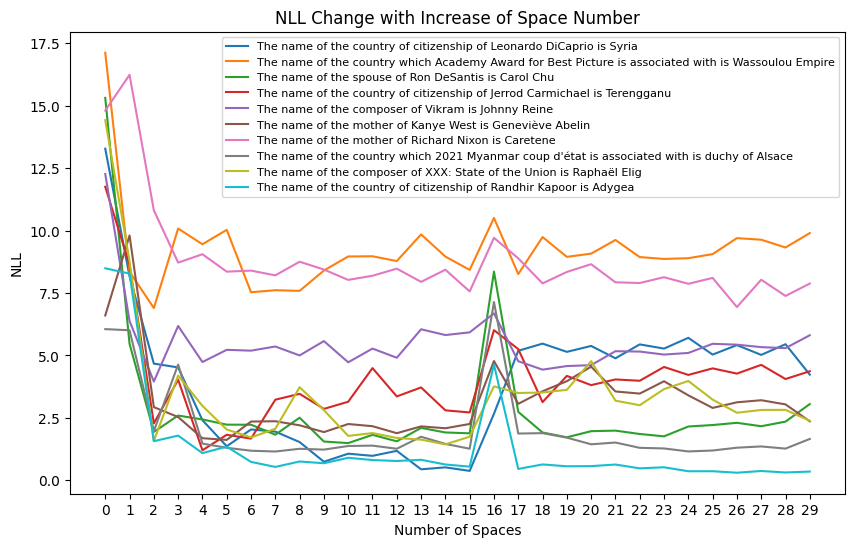

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

# Extract the NLL values for each space number
space_numbers = [str(i) for i in range(30)]
for result in add_space_results:
    nll_values = []
    for space_number in space_numbers:
        nll_values.append(result[str(space_number)])
    plt.plot(space_numbers, nll_values,label=result['edited_sentence']+" "+result['edited_sentence_answer'])
plt.legend(fontsize=8)  # You can also use specific sizes like 10, 12, etc.
plt.xlabel('Number of Spaces')
plt.ylabel('NLL')
plt.title('NLL Change with Increase of Space Number')
plt.show()

In [3]:
for i in range(20):
    print(tokenizer.encode(" "*i))

[1]
[1, 259]
[1, 1678]
[1, 268]
[1, 418]
[1, 539]
[1, 4706]
[1, 308]
[1, 3986]
[1, 965]
[1, 9651]
[1, 632]
[1, 795]
[1, 1669]
[1, 18884]
[1, 462]
[1, 462, 29871]
[1, 462, 259]
[1, 462, 1678]
[1, 462, 268]


In [31]:
def calculate_answer_probability_with_extra_token(
    model: AutoModelForCausalLM,
    tok: AutoTokenizer,
    prompt: str,
    answers: List[str],
    extra_token= List[int]
):
    calculate = []
    calculate_sum = 0
    for answer in answers:
        inp_tok = tok(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device) # inp_tok is the input_ids and attention_mask of the prompt
        
        whole_context_token = tok(prompt,padding=False,return_tensors="pt").to(next(model.parameters()).device)

        # insert extra token
        input_ids_extra_token = torch.tensor(extra_token).to(next(model.parameters()).device)
        input_ids_extra_token.to(torch.int)
        attention_ids_extra_token = torch.tensor([1]*len(extra_token)).to(next(model.parameters()).device)
        attention_ids_extra_token.to(torch.int)
        whole_context_token['input_ids'] = torch.cat((whole_context_token['input_ids'],input_ids_extra_token.unsqueeze(0)),dim=1)
        whole_context_token['attention_mask'] = torch.cat((whole_context_token['attention_mask'],attention_ids_extra_token.unsqueeze(0)),dim=1) 
        
        inp_len = len(whole_context_token['input_ids'][0])
        
        answer_token = tok(answer,padding=False,return_tensors="pt").to(next(model.parameters()).device)
        
        whole_context_token['input_ids'] = torch.cat((whole_context_token['input_ids'],answer_token['input_ids'][0,1:].unsqueeze(0)),dim=1)
        whole_context_token['attention_mask'] = torch.cat((whole_context_token['attention_mask'],answer_token['attention_mask'][0,1:].unsqueeze(0)),dim=1)

        print(whole_context_token)
    #     # input and generate
        model_out = model(**whole_context_token)
        logits, past_key_values = model_out.logits, model_out.past_key_values
        output_logits = logits[:,inp_len-1:-1,:] # output_logits is the logits of the answer, need to remove 1 position
        length = output_logits.shape[1]
        softmax_out = torch.nn.functional.softmax(output_logits,dim=-1)
        answer_logits = softmax_out[0,torch.arange(whole_context_token['input_ids'][0][inp_len:].shape[0]),whole_context_token['input_ids'][0][inp_len:]]
        calculate.append(torch.prod(answer_logits))
        calculate_sum += torch.prod(answer_logits)
    print("prompt:" + prompt)
    print("answers:" + answers[0])
    calculate_sum = torch.log(calculate_sum)
    print("NLL:"+str((-1)*calculate_sum.item()))
    
    return {
        "prompt": prompt,
        "answers": answers,
        "NLL": (-1)*calculate_sum.item(),
    } # return the log probability of  each answer

In [32]:
add_space_results = []
for one_data in tqdm(test_data[:10]):
    one_data_result = {}
    edited_data = make_edited_data(one_data)
    edited_sentence_answer = edited_data['target']
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    # suppress print
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=False,return_diff_weights=True)
        one_data_result['edited_sentence'] = edited_sentence
        one_data_result['edited_sentence_answer'] = edited_sentence_answer
    # for i in range(10):
    #     calculate_answer_probability_with_extra_token(model_edited,tokenizer,edited_sentence,[edited_sentence_answer],extra_token=[259]*(i+1))
        for i in range(10):
            one_data_result[str(i)] = calculate_answer_probability_with_extra_token(model_edited,tokenizer,edited_sentence,[edited_sentence_answer],extra_token=[259]*(i+1))['NLL']
    add_space_results.append(one_data_result)

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


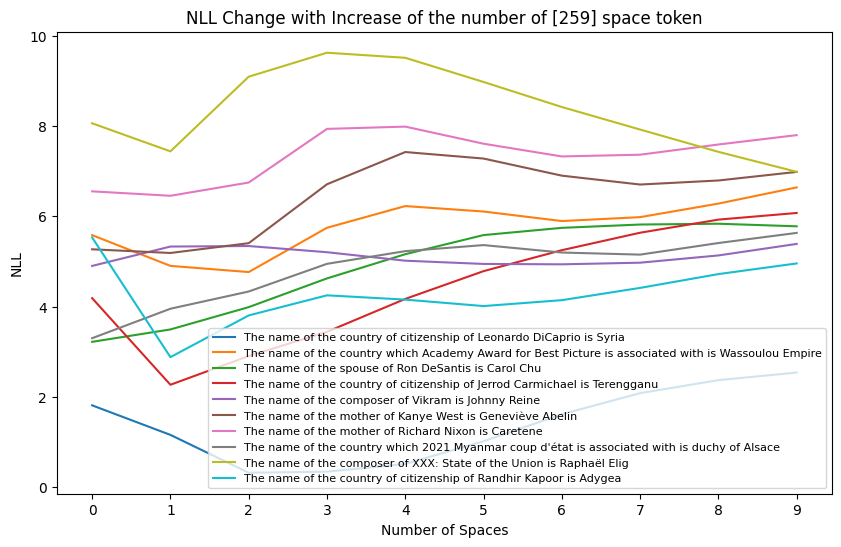

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

# Extract the NLL values for each space number
space_numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for result in add_space_results:
    nll_values = []
    for space_number in space_numbers:
        nll_values.append(result[str(space_number)])
    plt.plot(space_numbers, nll_values,label=result['edited_sentence']+" "+result['edited_sentence_answer'])
plt.legend(fontsize=8)  # You can also use specific sizes like 10, 12, etc.
plt.xlabel('Number of Spaces')
plt.ylabel('NLL')
plt.title('NLL Change with Increase of the number of [259] space token')
plt.show()

